In [12]:
import pandas as pd
import numpy as np

import operator 

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv("../PMD_Analysis/data/pmd_full_4.txt",sep = "\t", header=None)

In [3]:
data.columns = ['encrypted_customer_id','is_promo','is_pmd','revenue','units','min_date','max_date']


data['min_date'] = pd.to_datetime(data['min_date'])
data['max_date'] = pd.to_datetime(data['max_date'])

In [ ]:
data.shape

(4873194, 7)

In [ ]:
print(data.shape)
print(data['encrypted_customer_id'].nunique())
data.head()

2113141


,encrypted_customer_id,is_promo,is_pmd,revenue,units,min_date,max_date
0,A29NFF34BNM6WI,non_promo,non_pmd,49.01,11,2016-12-23,2019-05-20
1,A2XOOG7N9LBM2D,non_promo,non_pmd,289.94,72,2015-08-18,2019-07-06
2,A37HBT237VVUN7,non_promo,non_pmd,3358.30,343,2014-12-06,2019-05-30
3,APLRQYYT84YUL,promo,non_pmd,8.31,2,2018-11-26,2019-02-24
4,A1R8G0LEHUYM9,non_promo,non_pmd,1926.09,474,2015-03-14,2019-07-06


# Part One - how many customers have only pmd

In [ ]:
table = pd.pivot_table(data, values='units', index=['encrypted_customer_id'],
                       columns=['is_pmd'], aggfunc=np.sum, fill_value=0).reset_index()

In [ ]:
table.head()

is_pmd,encrypted_customer_id,is_pmd,non_pmd
0,A0000366A0GK5998YBDT,1,71
1,A0000666DG4NFCAMI8,5,30
2,A0001210LXBR1BZ5BP3,13,19
3,A00014502OC4OBEX6TX4A,1,1
4,A0002142161IPUDSA8D6H,4,27


In [ ]:
table[table['non_pmd'] == 0].shape[0] / table['encrypted_customer_id'].nunique()

0.037025451685429416

In [ ]:
table[table['non_pmd'] == 0].tail()

is_pmd,encrypted_customer_id,is_pmd,non_pmd
2113077,AZZV50VYBWJ11,5,0
2113104,AZZX1XYC5954A,1,0
2113124,AZZYC5ZA1SQUR,3,0
2113127,AZZYO1YQ1HWI5,1,0
2113136,AZZZRNKD8SDUD,2,0


In [ ]:
data[data['encrypted_customer_id'] == 'A0000666DG4NFCAMI8']

,encrypted_customer_id,is_promo,is_pmd,revenue,units,min_date,max_date
86995,A0000666DG4NFCAMI8,non_promo,non_pmd,110.65,27,2016-01-24,2019-06-01
2634146,A0000666DG4NFCAMI8,promo,is_pmd,15.91,5,2017-05-26,2018-11-23
3714286,A0000666DG4NFCAMI8,promo,non_pmd,12.57,3,2018-12-18,2018-12-23


# Part Two - sampled 

In [13]:
df = pd.read_csv("../PMD_Analysis/data/sampled_4.txt", sep = "\t", header=None)

In [14]:
df.columns = ['encrypted_customer_id','is_promo','is_pmd','fufill_date_local',
              'revenue','units','min_date','max_date']

print(df.shape)
df.head()

(3724902, 8)


,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date
0,A1Z6ILI5TVKPVM,non_promo,non_pmd,2018-09-10 00:00:00,4.19,1,2018-09-10 00:00:00,2018-09-10 00:00:00
1,AVS12S9CYRCAS,non_promo,non_pmd,2016-09-29 00:00:00,3.35,1,2016-09-29 00:00:00,2016-09-29 00:00:00
2,ARPSGWMT41RT5,non_promo,non_pmd,2017-11-03 00:00:00,11.66,1,2017-11-03 00:00:00,2017-11-03 00:00:00
3,A2T6H4C9A0FTCH,non_promo,non_pmd,2016-08-17 00:00:00,11.75,2,2016-08-17 00:00:00,2016-08-17 00:00:00
4,A166HVMSWMRMIG,non_promo,non_pmd,2018-06-20 00:00:00,8.36,4,2018-06-20 00:00:00,2018-06-20 00:00:00


In [15]:
df[(df['is_promo'] == 'promo') & (df['is_pmd'] == 'is_pmd')]['fufill_date_local'].min()

'2015-07-24 00:00:00'

In [16]:
def first_pmd_event(df):
    
    """Create function to add first PMD column per customer """ 
    
    df['fufill_date_local'] = pd.to_datetime(df['fufill_date_local'])
    df['min_date'] = pd.to_datetime(df['min_date'])
    df['max_date'] = pd.to_datetime(df['max_date'])
    
    first_pmd = df[df['is_pmd'] == 'is_pmd'].groupby("encrypted_customer_id")['fufill_date_local'].min().reset_index()
    
    df_new = pd.merge(left = df, right = first_pmd, left_on = ['encrypted_customer_id'],
                     right_on = ['encrypted_customer_id'], how = 'left')
    
    df_new.columns = ['encrypted_customer_id','is_promo','is_pmd','fufill_date_local',
              'revenue','units','min_date','max_date','first_pmd_date']
    
    first_ever = df.groupby('encrypted_customer_id')['fufill_date_local'].min().reset_index()
    first_ever.columns = ['encrypted_customer_id','first_ever_purchase_date']
    
    df_new = pd.merge(left = df_new, right = first_ever, left_on = ['encrypted_customer_id'],
                     right_on = ['encrypted_customer_id'], how = 'left')
    
    
    return df_new

In [17]:
df_new = first_pmd_event(df)

In [18]:
print(df_new['first_pmd_date'].min())
df_new.head()

2015-07-24 00:00:00


,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date,first_pmd_date,first_ever_purchase_date
0,A1Z6ILI5TVKPVM,non_promo,non_pmd,2018-09-10,4.19,1,2018-09-10,2018-09-10,2018-09-14,2017-10-28
1,AVS12S9CYRCAS,non_promo,non_pmd,2016-09-29,3.35,1,2016-09-29,2016-09-29,NaT,2014-07-28
2,ARPSGWMT41RT5,non_promo,non_pmd,2017-11-03,11.66,1,2017-11-03,2017-11-03,2019-04-06,2015-01-11
3,A2T6H4C9A0FTCH,non_promo,non_pmd,2016-08-17,11.75,2,2016-08-17,2016-08-17,2018-07-15,2015-08-04
4,A166HVMSWMRMIG,non_promo,non_pmd,2018-06-20,8.36,4,2018-06-20,2018-06-20,2018-12-29,2016-06-06


In [20]:
table_pivot = pd.pivot_table(df_new, values='units', index=['encrypted_customer_id'],
                       columns=['is_pmd'], aggfunc=np.sum, fill_value=0).reset_index()

In [21]:
print("What proportion of PMD customers exclusively buy only PMD: ")
table_pivot[table_pivot['non_pmd'] == 0].shape[0] /  df_new['encrypted_customer_id'].nunique()

What proportion of PMD customers exclusively buy only PMD: 


0.03208

# Part Three - customers who purchased both

## Distribute frequency and units before and after first PMD

In [24]:
def split_initial_dataframe(df, comparator ):
    
    """function uses operator library to slice dataframe by dates relative to a reference timestamp.
    It allows to split the dataframe into 2 cohorts and see 
    """
    
    metrics_by_Promo =        df[comparator].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['units','revenue'].sum().reset_index()
    first_purchase_by_Promo = df[comparator].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['fufill_date_local'].min().reset_index()
    first_ever_purchase =     df[comparator].groupby(["encrypted_customer_id"])['fufill_date_local'].min().reset_index()
    last_purchase =           df[comparator].groupby(["encrypted_customer_id"])['fufill_date_local'].max().reset_index()
    last_purchase_by_Promo =  df[comparator].groupby(["encrypted_customer_id",'is_promo','is_pmd'])['fufill_date_local'].max().reset_index()
    
    df1 = pd.merge(left = metrics_by_Promo, right = first_purchase_by_Promo,
                   left_on = ["encrypted_customer_id",'is_promo','is_pmd'],
                   right_on = ["encrypted_customer_id",'is_promo','is_pmd'], how= 'left')
    
    df2 = pd.merge(left = df1, right = last_purchase_by_Promo,
                   left_on = ["encrypted_customer_id",'is_promo','is_pmd'],
                   right_on = ["encrypted_customer_id",'is_promo','is_pmd'], how= 'left')
    
    df3 = pd.merge(left=df2, right = first_ever_purchase,
                   left_on=["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    
    df4 = pd.merge(left = df3, right = last_purchase,
                   left_on=["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    
    df4.columns = ['encrypted_customer_id','is_promo','is_pmd','units','revenue',
                   'first_date_byPromo','last_date_byPromo','first_everdate','last_ever_date']
    
    df4['frequency_days_byPromo'] = (( df4['last_date_byPromo'] - df4['first_date_byPromo'] )
                                / np.timedelta64(1,"D") ) / (df4['units'] - 1)
    
   
    
    metrics_before_first_PMD = df[comparator].groupby(["encrypted_customer_id"])['units','revenue'].sum().reset_index()
    
    
    df5 = pd.merge(left = df4, right = metrics_before_first_PMD,
                   left_on = ["encrypted_customer_id"],
                   right_on = ["encrypted_customer_id"], how= 'left')
    
    df5.columns = ['encrypted_customer_id','is_promo','is_pmd','units_byPromo','revenue_byPromo',
                   'first_date_byPromo','last_date_byPromo','first_ever_date','last_ever_date',
                   'frequency_days_byPromo','units_ever','revenue_ever']
    
    df5['frequency_days_general'] = (( df5['last_ever_date'] - df5['first_ever_date'] )
                                / np.timedelta64(1,"D") ) / (df5['units_ever'] - 1)
    df5 = df5.fillna(0)
    
    df5['ASP'] = df5['revenue_ever'] / df5['units_ever'] 
    df5['share_as_total'] = df5['units_byPromo'] / df5['units_ever']
    
    df5['timeframe_general'] = (( df5['last_ever_date'] - df5['first_ever_date'] ) / np.timedelta64(1,"M") ) 
    df5['timeframe_general_by_Promo'] = (( df5['last_date_byPromo'] - df5['first_date_byPromo'] ) / np.timedelta64(1,"M") ) 
    
    
    
    return df5

In [25]:
def to_label(df1, df2, comparator):
    """function labels the customers according to their engagement in the period before intervention,
    ie how many transactions did they did before they were subject to intervention"""
    metrics_before_first_PMD = df1[comparator].groupby(["encrypted_customer_id"])['units','revenue'].sum().reset_index()
    
    df2['label'] = np.select(
        [
                    df2['units_ever'] <   metrics_before_first_PMD['units'].quantile(0.25),
        
                    (df2['units_ever'] >= metrics_before_first_PMD['units'].quantile(0.25)  ) & 
                    (df2['units_ever'] <  metrics_before_first_PMD['units'].quantile(0.50)  ),
        
                    (df2['units_ever'] >= metrics_before_first_PMD['units'].quantile(0.5)   ) &
                    (df2['units_ever'] <  metrics_before_first_PMD['units'].quantile(0.75)  ),
                    
                    df2['units_ever'] >=  metrics_before_first_PMD['units'].quantile(0.75) 
        ],
        [
            'A_Below_25',
            'B_Between_25_50',
            'C_Between_50_75',
            'D_Above_75'
        ],
        default = 'E_Unknown'

    )
    
    return df2

In [26]:
before = split_initial_dataframe(df_new, operator.lt(df_new['fufill_date_local'], df_new['first_pmd_date']))
before = to_label(df_new, before , operator.lt(df_new['fufill_date_local'], df_new['first_pmd_date']))

In [27]:
print(before.shape)
before.head()

(121361, 18)


,encrypted_customer_id,is_promo,is_pmd,units_byPromo,revenue_byPromo,first_date_byPromo,last_date_byPromo,first_ever_date,last_ever_date,frequency_days_byPromo,units_ever,revenue_ever,frequency_days_general,ASP,share_as_total,timeframe_general,timeframe_general_by_Promo,label
0,A00042303E2M3H533IK8P,non_promo,non_pmd,6,24.30,2016-04-01,2016-08-21,2016-04-01,2016-08-21,28.400000,6,24.30,28.400000,4.050,1.0000,4.665394,4.665394,B_Between_25_50
1,A00084501PGU2JYYUI2XR,non_promo,non_pmd,15,47.73,2017-01-04,2018-07-08,2017-01-04,2018-07-08,39.285714,16,48.56,36.666667,3.035,0.9375,18.070186,18.070186,C_Between_50_75
2,A00084501PGU2JYYUI2XR,promo,non_pmd,1,0.83,2017-11-26,2017-11-26,2017-01-04,2018-07-08,0.000000,16,48.56,36.666667,3.035,0.0625,18.070186,0.000000,C_Between_50_75
3,A00176501NI9ZN1E2ZXZI,non_promo,non_pmd,14,68.25,2016-04-15,2017-05-06,2016-04-15,2017-05-06,29.692308,14,68.25,29.692308,4.875,1.0000,12.681985,12.681985,C_Between_50_75
4,A0017882RE2NT311GWQN,non_promo,non_pmd,2,8.38,2018-05-16,2018-07-08,2018-05-16,2018-07-08,53.000000,2,8.38,53.000000,4.190,1.0000,1.741309,1.741309,A_Below_25


#### Make a subset to look only at those who did any transaction  before PMD

In [28]:
subset = df_new[df_new['encrypted_customer_id'].isin(before['encrypted_customer_id'])]

In [29]:
after = split_initial_dataframe(subset, operator.ge(subset['fufill_date_local'], subset['first_pmd_date']))

In [30]:
print(after.shape)
after.head()

(196373, 17)


,encrypted_customer_id,is_promo,is_pmd,units_byPromo,revenue_byPromo,first_date_byPromo,last_date_byPromo,first_ever_date,last_ever_date,frequency_days_byPromo,units_ever,revenue_ever,frequency_days_general,ASP,share_as_total,timeframe_general,timeframe_general_by_Promo
0,A00042303E2M3H533IK8P,non_promo,non_pmd,69,332.04,2016-11-23,2019-06-20,2016-11-04,2019-06-20,13.808824,95,397.26,10.191489,4.181684,0.726316,31.474979,30.850736
1,A00042303E2M3H533IK8P,promo,is_pmd,14,11.62,2016-11-04,2019-03-02,2016-11-04,2019-06-20,65.230769,95,397.26,10.191489,4.181684,0.147368,31.474979,27.860942
2,A00042303E2M3H533IK8P,promo,non_pmd,12,53.60,2017-04-29,2019-03-17,2016-11-04,2019-06-20,62.454545,95,397.26,10.191489,4.181684,0.126316,31.474979,22.571305
3,A00084501PGU2JYYUI2XR,non_promo,non_pmd,12,34.32,2018-09-10,2019-05-08,2018-07-13,2019-07-12,21.818182,38,92.44,9.837838,2.432632,0.315789,11.959178,7.885172
4,A00084501PGU2JYYUI2XR,promo,is_pmd,23,53.53,2018-07-13,2019-07-12,2018-07-13,2019-07-12,16.545455,38,92.44,9.837838,2.432632,0.605263,11.959178,11.959178


## Change in frequency of purchasing OVERALL

In [33]:
before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].mean()

57.14658326976853

In [34]:
before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].quantile([0.25,0.5,0.75])

0.25    11.578472
0.50    27.946657
0.75    63.440476
Name: frequency_days_general, dtype: float64

In [35]:
after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].mean()

30.275841254506577

In [36]:
after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'].quantile([0.25,0.5,0.75])

0.25     6.480519
0.50    16.413043
0.75    34.800000
Name: frequency_days_general, dtype: float64

### Visualization

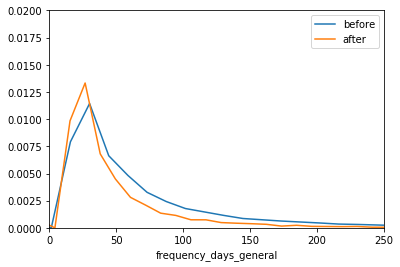

In [37]:
plt.xlim(0, 250)
plt.ylim(0, 0.02)
sns.distplot(before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = False, label = 'before')
sns.distplot(after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = False, label = 'after')
plt.show()

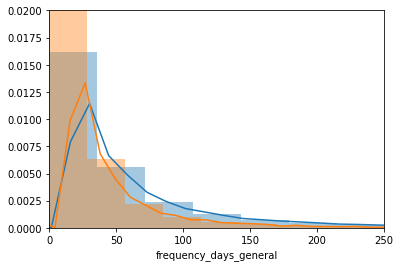

In [38]:
plt.xlim(0, 250)
plt.ylim(0, 0.02)
sns.distplot(before.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = True, label = 'before')
sns.distplot(after.groupby(['encrypted_customer_id'])['frequency_days_general'].mean().reset_index()['frequency_days_general'],
            hist = True, label = 'after')
plt.show()

## Change in frequency of purchasing by Bucket Before and After PMD

In [82]:
def attach_labels(source_df, destination_df):
    
    #from before
    
    labels = source_df[['encrypted_customer_id','label']]
    labels = labels.drop_duplicates()
    output = pd.merge(left = destination_df, right = labels,
                        left_on=['encrypted_customer_id'], right_on = ['encrypted_customer_id'], how = 'left')
    
    return output

In [85]:
after_labels = attach_labels(before, after)

In [86]:
before.groupby(['label'])['frequency_days_general'].mean().reset_index()

,label,frequency_days_general
0,A_Below_25,96.376265
1,B_Between_25_50,82.713378
2,C_Between_50_75,42.666721
3,D_Above_75,17.670586


In [87]:
after_labels.groupby(['label'])['frequency_days_general'].mean().reset_index()

,label,frequency_days_general
0,A_Below_25,50.540768
1,B_Between_25_50,37.132811
2,C_Between_50_75,26.576836
3,D_Above_75,15.103617


In [88]:
before['units_ever'].quantile([0.25,0.50,0.75])

0.25     5.0
0.50    14.0
0.75    35.0
Name: units_ever, dtype: float64

### Change in shares of promo / non promo purchases by Bucket by Promo

In [89]:
def get_share(df):
    
    """look into the share of transactions which are promotional"""
    
    a = df.groupby(['is_promo','is_pmd','label'])['units_byPromo'].sum().reset_index()
    b = pd.merge(left = a,right = a.groupby(['label'])['units_byPromo'].sum().reset_index(),
            left_on = ['label'], right_on = ['label'], how = 'left')
    b['share'] = b['units_byPromo_x'] / b['units_byPromo_y']
    return b

In [90]:
b = get_share(before)
b

,is_promo,is_pmd,label,units_byPromo_x,units_byPromo_y,share
0,non_promo,non_pmd,A_Below_25,31238,34361,0.909112
1,non_promo,non_pmd,B_Between_25_50,131290,145478,0.902473
2,non_promo,non_pmd,C_Between_50_75,338013,371941,0.908781
3,non_promo,non_pmd,D_Above_75,1434558,1543257,0.929565
4,promo,non_pmd,A_Below_25,3123,34361,0.090888
5,promo,non_pmd,B_Between_25_50,14188,145478,0.097527
6,promo,non_pmd,C_Between_50_75,33928,371941,0.091219
7,promo,non_pmd,D_Above_75,108699,1543257,0.070435


In [91]:
a = get_share(after_labels)
a

,is_promo,is_pmd,label,units_byPromo_x,units_byPromo_y,share
0,non_promo,non_pmd,A_Below_25,171019,308761,0.553888
1,non_promo,non_pmd,B_Between_25_50,274581,442753,0.620167
2,non_promo,non_pmd,C_Between_50_75,388774,564495,0.688711
3,non_promo,non_pmd,D_Above_75,687663,881409,0.780186
4,promo,is_pmd,A_Below_25,96763,308761,0.313391
5,promo,is_pmd,B_Between_25_50,112094,442753,0.253175
6,promo,is_pmd,C_Between_50_75,106745,564495,0.189098
7,promo,is_pmd,D_Above_75,90392,881409,0.102554
8,promo,non_pmd,A_Below_25,40979,308761,0.132721
9,promo,non_pmd,B_Between_25_50,56078,442753,0.126658


### Change in frequency of purchasing by Bucket Before and After PMD by Promo

In [92]:
before.groupby(['is_promo','is_pmd','label'])['frequency_days_byPromo'].mean().reset_index()

,is_promo,is_pmd,label,frequency_days_byPromo
0,non_promo,non_pmd,A_Below_25,86.625640
1,non_promo,non_pmd,B_Between_25_50,91.943256
2,non_promo,non_pmd,C_Between_50_75,47.155559
3,non_promo,non_pmd,D_Above_75,19.195114
4,promo,non_pmd,A_Below_25,13.589419
5,promo,non_pmd,B_Between_25_50,40.322058
6,promo,non_pmd,C_Between_50_75,66.123653
7,promo,non_pmd,D_Above_75,77.174953


In [93]:
after_labels.groupby(['is_promo','is_pmd','label'])['frequency_days_byPromo'].mean().reset_index()

,is_promo,is_pmd,label,frequency_days_byPromo
0,non_promo,non_pmd,A_Below_25,55.048636
1,non_promo,non_pmd,B_Between_25_50,43.727406
2,non_promo,non_pmd,C_Between_50_75,32.526047
3,non_promo,non_pmd,D_Above_75,19.331832
4,promo,is_pmd,A_Below_25,66.673071
5,promo,is_pmd,B_Between_25_50,69.445622
6,promo,is_pmd,C_Between_50_75,71.969557
7,promo,is_pmd,D_Above_75,71.099791
8,promo,non_pmd,A_Below_25,69.425184
9,promo,non_pmd,B_Between_25_50,70.226803


### Change in ARPU AND ASP by Bucket Before and After PMD by Promo

In [94]:
before.groupby(['is_promo','is_pmd','label'])['ASP'].mean().reset_index()

,is_promo,is_pmd,label,ASP
0,non_promo,non_pmd,A_Below_25,4.490347
1,non_promo,non_pmd,B_Between_25_50,4.616081
2,non_promo,non_pmd,C_Between_50_75,4.755418
3,non_promo,non_pmd,D_Above_75,5.053699
4,promo,non_pmd,A_Below_25,4.645252
5,promo,non_pmd,B_Between_25_50,4.930808
6,promo,non_pmd,C_Between_50_75,5.023569
7,promo,non_pmd,D_Above_75,5.246418


In [95]:
after_labels.groupby(['is_promo','is_pmd','label'])['ASP'].mean().reset_index()

,is_promo,is_pmd,label,ASP
0,non_promo,non_pmd,A_Below_25,3.252859
1,non_promo,non_pmd,B_Between_25_50,3.628935
2,non_promo,non_pmd,C_Between_50_75,4.033277
3,non_promo,non_pmd,D_Above_75,4.732630
4,promo,is_pmd,A_Below_25,2.839960
5,promo,is_pmd,B_Between_25_50,3.296607
6,promo,is_pmd,C_Between_50_75,3.788867
7,promo,is_pmd,D_Above_75,4.556586
8,promo,non_pmd,A_Below_25,3.262658
9,promo,non_pmd,B_Between_25_50,3.753195


### Change in total ARPU by Bucket Before and After PMD by Promo

In [168]:
def get_subset_for_ARPU(df):
    
    get_that = df[['encrypted_customer_id','label','revenue_ever','units_ever','timeframe_general','is_promo','is_pmd']]
    get_that['corrected_timeframe_general'] = np.where(get_that['timeframe_general'] == 0.0, 1.0, get_that['timeframe_general'])
    get_that = get_that.drop_duplicates()
    get_that['ARPU_monthly'] = get_that['revenue_ever'] / get_that['corrected_timeframe_general']
    get_that['units_monthly'] = get_that['units_ever'] / get_that['corrected_timeframe_general']
    get_that['ASP'] = get_that['revenue_ever'] / get_that['units_ever']

    return get_that

In [175]:
s_before = get_subset_for_ARPU(before)
s_after = get_subset_for_ARPU(after_labels)

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [170]:
s_before.groupby("label")['ARPU_monthly'].mean().reset_index()

,label,ARPU_monthly
0,A_Below_25,13.340478
1,B_Between_25_50,7.756039
2,C_Between_50_75,6.761686
3,D_Above_75,14.617128


In [171]:
s_before[s_before['encrypted_customer_id'] == 'A00084501PGU2JYYUI2XR']

,encrypted_customer_id,label,revenue_ever,units_ever,timeframe_general,is_promo,is_pmd,corrected_timeframe_general,ARPU_monthly,units_monthly,ASP
1,A00084501PGU2JYYUI2XR,C_Between_50_75,48.56,16,18.070186,non_promo,non_pmd,18.070186,2.687299,0.885436,3.035
2,A00084501PGU2JYYUI2XR,C_Between_50_75,48.56,16,18.070186,promo,non_pmd,18.070186,2.687299,0.885436,3.035


In [172]:
s_after[s_after['encrypted_customer_id'] == 'A00084501PGU2JYYUI2XR']

,encrypted_customer_id,label,revenue_ever,units_ever,timeframe_general,is_promo,is_pmd,corrected_timeframe_general,ARPU,units_monthly,ASP
3,A00084501PGU2JYYUI2XR,C_Between_50_75,92.44,38,11.959178,non_promo,non_pmd,11.959178,7.729628,3.177476,2.432632
4,A00084501PGU2JYYUI2XR,C_Between_50_75,92.44,38,11.959178,promo,is_pmd,11.959178,7.729628,3.177476,2.432632
5,A00084501PGU2JYYUI2XR,C_Between_50_75,92.44,38,11.959178,promo,non_pmd,11.959178,7.729628,3.177476,2.432632


In [174]:
s_before.groupby(["label",'is_promo','is_pmd'])['ARPU_monthly'].mean().reset_index()

,label,is_promo,is_pmd,ARPU_monthly
0,A_Below_25,non_promo,non_pmd,13.215342
1,A_Below_25,promo,non_pmd,14.150551
2,B_Between_25_50,non_promo,non_pmd,7.863727
3,B_Between_25_50,promo,non_pmd,7.465891
4,C_Between_50_75,non_promo,non_pmd,6.764411
5,C_Between_50_75,promo,non_pmd,6.756904
6,D_Above_75,non_promo,non_pmd,14.529701
7,D_Above_75,promo,non_pmd,14.731437


In [146]:
s_before.groupby(["label",'is_promo','is_pmd'])['units_monthly'].mean().reset_index()

,label,is_promo,is_pmd,units_monthly
0,A_Below_25,non_promo,non_pmd,2.925367
1,A_Below_25,promo,non_pmd,2.998285
2,B_Between_25_50,non_promo,non_pmd,1.699125
3,B_Between_25_50,promo,non_pmd,1.475371
4,C_Between_50_75,non_promo,non_pmd,1.466387
5,C_Between_50_75,promo,non_pmd,1.348742
6,D_Above_75,non_promo,non_pmd,2.882235
7,D_Above_75,promo,non_pmd,2.793214


In [147]:
print(s_before['ARPU'].quantile([0.1, 0.2, 0.25, 0.5 , 0.75, 0.8]))
print(s_before['ARPU'].mean())
print(s_before['ARPU'].median())

0.10     1.112674
0.20     1.905475
0.25     2.328629
0.50     4.755117
0.75    10.274805
0.80    12.456848
Name: ARPU, dtype: float64
10.53287096256785
4.75511686970339


In [176]:
s_after.groupby("label")['ARPU_monthly'].mean().reset_index()

,label,ARPU_monthly
0,A_Below_25,6.848450
1,B_Between_25_50,8.531823
2,C_Between_50_75,12.223742
3,D_Above_75,23.136991


In [150]:
s_after.groupby(["label",'is_promo','is_pmd'])['ARPU'].mean().reset_index()

,label,is_promo,is_pmd,ARPU
0,A_Below_25,non_promo,non_pmd,7.127372
1,A_Below_25,promo,is_pmd,6.907830
2,A_Below_25,promo,non_pmd,6.287018
3,B_Between_25_50,non_promo,non_pmd,8.742337
4,B_Between_25_50,promo,is_pmd,8.444690
5,B_Between_25_50,promo,non_pmd,8.379573
6,C_Between_50_75,non_promo,non_pmd,12.466162
7,C_Between_50_75,promo,is_pmd,12.328604
8,C_Between_50_75,promo,non_pmd,11.688780
9,D_Above_75,non_promo,non_pmd,24.088178


In [105]:
print(s_after['ARPU'].quantile([0.1, 0.2, 0.25, 0.5 , 0.75, 0.8]))
print(s_after['ARPU'].mean())
print(s_after['ARPU'].median())

0.10     1.083794
0.20     1.975392
0.25     2.490000
0.50     5.595828
0.75    12.040555
0.80    14.549064
Name: ARPU, dtype: float64
13.20438545559917
5.595827606951872


### Visiualize

### Change in distribution by Bucket Before and After PMD by Promo

In [177]:
# Subset only those who made PMD

pmd_subset = df_new[df_new['is_pmd'] == 'is_pmd']
pmd_subset['month_year'] = pmd_subset['fufill_date_local'].dt.to_period('M')

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [178]:
pmd_subset.groupby(['month_year','encrypted_customer_id'])['units'].sum().reset_index().head()

,month_year,encrypted_customer_id,units
0,2015-07,A004780624A0CUJUBUVYC,1
1,2015-07,A060147737X889HT3FCEG,1
2,2015-07,A100EEBA2T9Q40,1
3,2015-07,A102FR6G3S3YTT,2
4,2015-07,A108KGYAVLGQ5D,1


### Distribution by month

In [179]:
def prepare_dist(df):
    
    dist = df.groupby(['month_year','units'])['encrypted_customer_id'].nunique().reset_index()
    dist['month_year_date'] = dist['month_year'].apply(lambda x : x.to_timestamp())
    total = dist.groupby("month_year_date")['encrypted_customer_id'].sum().reset_index()
    dist = pd.merge(left=dist,right=total,left_on=['month_year_date'], right_on=['month_year_date'], how = 'left')
    dist['share'] = dist['encrypted_customer_id_x'] / dist['encrypted_customer_id_y']
    
    
    dist['buckets'] = np.select(
        [
                    dist['units'] == 1,
        
                    dist['units'] == 2,
                     
                    (dist['units'] >=  3 ) &
                    (dist['units'] <=  5 ),
                    
                   dist['units'] > 5 
        ],
        [
            'A_one',
            'B_two',
            'C_three_to_five',
            'D_above_five'
        ],
        default = 'E_Unknown')
        
    return dist

In [112]:
dist = prepare_dist(pmd_subset)

In [180]:
to_pivot_this = dist.groupby(['month_year','buckets'])['share'].sum().reset_index()
to_pivot_this.head()

,month_year,buckets,share
0,2015-07,A_one,0.578212
1,2015-07,B_two,0.194134
2,2015-07,C_three_to_five,0.203445
3,2015-07,D_above_five,0.024209
4,2015-08,A_one,0.779715


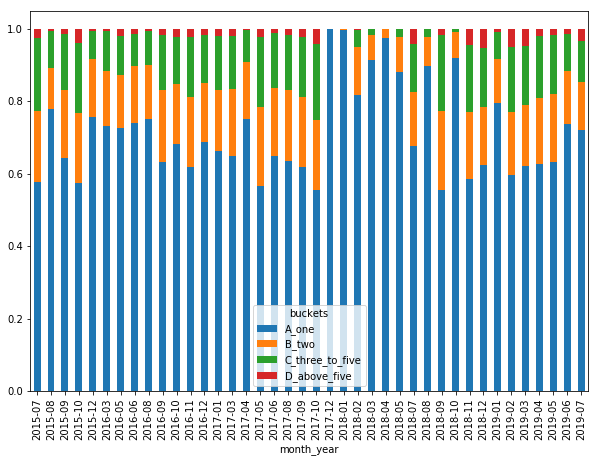

In [181]:
pivot_df = to_pivot_this.pivot(index='month_year', columns='buckets', values='share')
pivot_df.plot.bar(stacked=True, figsize=(10,7))

In [ ]:
#pivot_df.to_csv("DE_dist.csv")

### Build Cohorts

In [117]:
def prepare_to_next(df):
    dist = df.groupby(['month_year','encrypted_customer_id'])['units'].sum().reset_index()
    dist['month_year_date'] = dist['month_year'].apply(lambda x : x.to_timestamp())
    return dist

In [118]:
d = prepare_to_next(pmd_subset)
d.head()

,month_year,encrypted_customer_id,units,month_year_date
0,2015-07,A004780624A0CUJUBUVYC,1,2015-07-01
1,2015-07,A060147737X889HT3FCEG,1,2015-07-01
2,2015-07,A100EEBA2T9Q40,1,2015-07-01
3,2015-07,A102FR6G3S3YTT,2,2015-07-01
4,2015-07,A108KGYAVLGQ5D,1,2015-07-01


#### Create a period column based on the OrderDate 

In [119]:
pmd_subset['month_year_proper'] = pmd_subset['fufill_date_local'].apply(lambda x: x.strftime("%Y-%m"))

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


#### Determine the user's cohort group (based on their first order)

In [120]:
pmd_subset.set_index('encrypted_customer_id', inplace=True)

pmd_subset['CohortGroup'] = pmd_subset.groupby(level=0)['fufill_date_local'].min().apply(lambda x: x.strftime('%Y-%m'))
pmd_subset.reset_index(inplace=True)
pmd_subset.head()

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date,first_pmd_date,first_ever_purchase_date,month_year,month_year_proper,CohortGroup
0,A28KRLQRTHHQE1,promo,is_pmd,2019-05-03,0.83,1,2019-05-03,2019-05-03,2018-07-15,2018-07-15,2019-05,2019-05,2018-07
1,ALDBIOUE2WUA4,promo,is_pmd,2018-12-28,2.49,3,2018-12-28,2018-12-28,2016-09-30,2015-07-05,2018-12,2018-12,2016-09
2,AV0S058YGG9PN,promo,is_pmd,2019-03-03,0.82,1,2019-03-03,2019-03-03,2019-03-03,2018-06-04,2019-03,2019-03,2019-03
3,A2J6Y1GA092Y3W,promo,is_pmd,2018-11-23,0.83,1,2018-11-23,2018-11-23,2015-07-24,2015-07-24,2018-11,2018-11,2015-07
4,AZMZ0DSLR5IBS,promo,is_pmd,2019-04-05,0.83,1,2019-04-05,2019-04-05,2016-12-30,2016-10-16,2019-04,2019-04,2016-12


#### Rollup data by CohortGroup & OrderPeriod

In [121]:
grouped = pmd_subset.groupby(['CohortGroup', 'month_year_proper'])

# count the unique users, orders, and total revenue per Group + Period
cohorts = grouped.agg({'encrypted_customer_id': pd.Series.nunique,
                       'units': np.sum,
                       'revenue': np.sum})

# make the column names more meaningful
cohorts.rename(columns={'UserId': 'encrypted_customer_id',
                        'OrderId': 'units'}, inplace=True)
cohorts.head()

encrypted_customer_id  units  revenue
CohortGroup month_year_proper                                       
2015-07     2015-07                             2141   4011  3329.13
            2015-08                              230    423   351.09
            2015-09                              456   1117   927.11
            2015-10                              249    629   522.07
            2015-12                              243    422   350.26

#### Label the CohortPeriod for each CohortGroup

In [122]:
def cohort_period(df):
    """
    Creates a `CohortPeriod` column, which is the Nth period based on the user's first purchase.
    
    Example
    -------
    Say you want to get the 3rd month for every user:
        df.sort(['UserId', 'OrderTime', inplace=True)
        df = df.groupby('UserId').apply(cohort_period)
        df[df.CohortPeriod == 3]
    """
    df['CohortPeriod'] = np.arange(len(df)) + 1
    return df

cohorts = cohorts.groupby(level=0).apply(cohort_period)
cohorts.head()

encrypted_customer_id  units  revenue  \
CohortGroup month_year_proper                                          
2015-07     2015-07                             2141   4011  3329.13   
            2015-08                              230    423   351.09   
            2015-09                              456   1117   927.11   
            2015-10                              249    629   522.07   
            2015-12                              243    422   350.26   

                               CohortPeriod  
CohortGroup month_year_proper                
2015-07     2015-07                       1  
            2015-08                       2  
            2015-09                       3  
            2015-10                       4  
            2015-12                       5

#### User Retention by Cohort Group

In [126]:
# reindex the DataFrame
cohorts.reset_index(inplace=True)
cohorts.set_index(['CohortGroup', 'CohortPeriod'], inplace=True)

# create a Series holding the total size of each CohortGroup
cohort_group_size = cohorts['encrypted_customer_id'].groupby(level=0).first()

In [124]:
user_retention = cohorts['encrypted_customer_id'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head()

CohortGroup,2015-07,2015-08,2015-09,2015-10,2015-12,2016-03,2016-05,2016-06,2016-08,2016-09,...,2018-10,2018-11,2018-12,2019-01,2019-02,2019-03,2019-04,2019-05,2019-06,2019-07
CohortPeriod,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.107426,0.195822,0.129736,0.085057,0.036994,0.084646,0.156643,0.104031,0.251608,0.059662,...,0.102041,0.175669,0.010528,0.048589,0.172676,0.046983,0.130092,0.101241,0.162896,NaN
3,0.212985,0.117493,0.119403,0.057471,0.046243,0.129921,0.083916,0.226268,0.083601,0.212046,...,0.163265,0.014112,0.081591,0.090909,0.073529,0.072371,0.099212,0.121024,NaN,NaN
4,0.116301,0.112272,0.050517,0.073563,0.097110,0.074803,0.248951,0.073472,0.179260,0.142124,...,0.040816,0.088078,0.139348,0.047022,0.101044,0.067590,0.109724,NaN,NaN,NaN
5,0.113498,0.073107,0.076923,0.160920,0.078613,0.255906,0.072727,0.191157,0.164791,0.110963,...,0.142857,0.163747,0.064337,0.070533,0.088710,0.106825,NaN,NaN,NaN,NaN


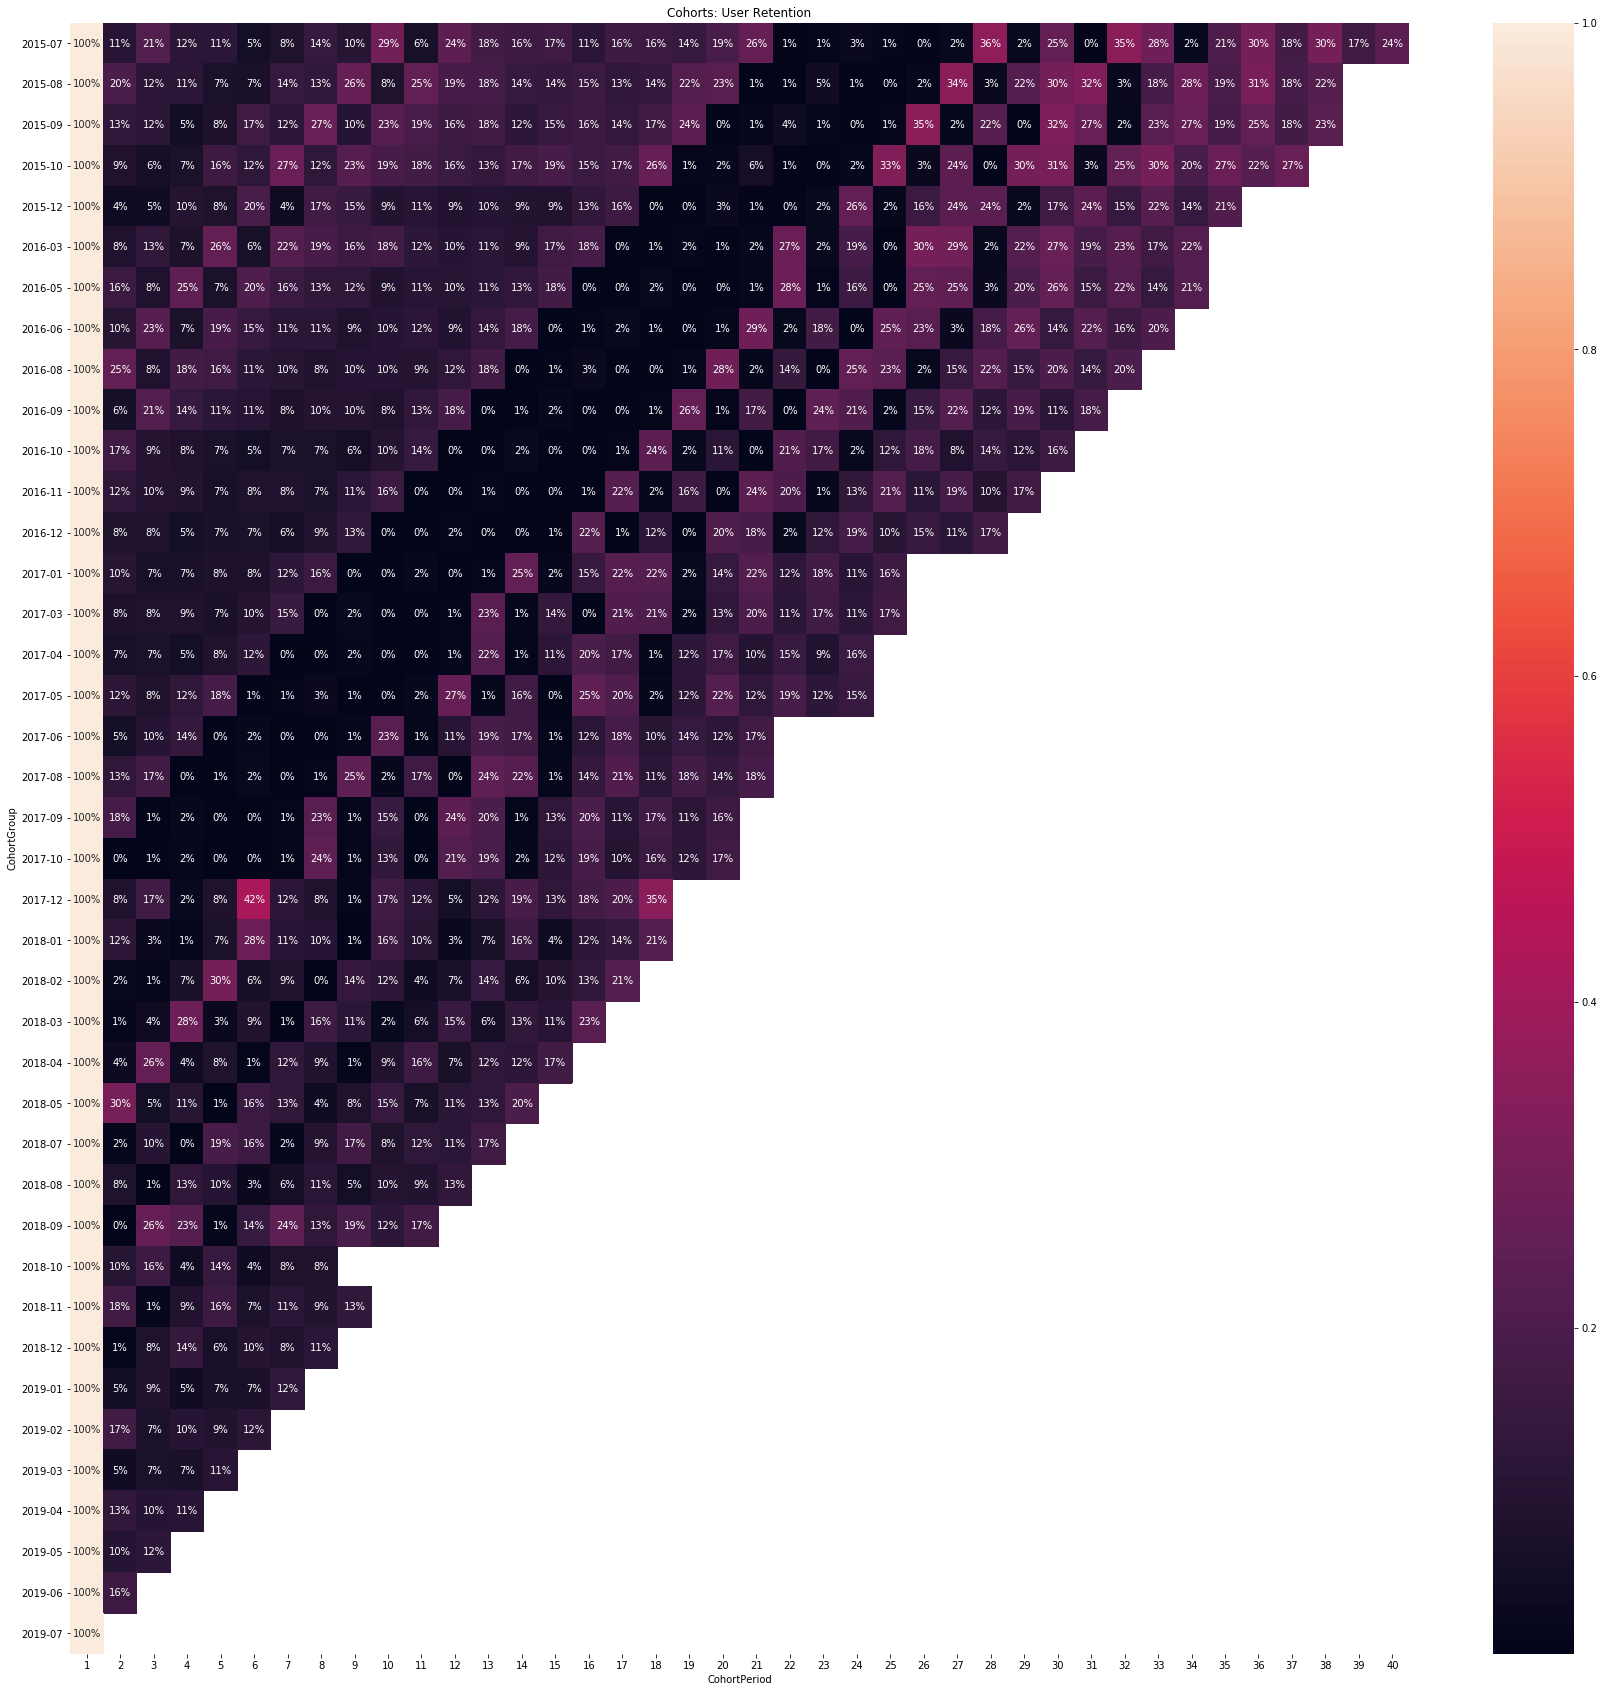

In [125]:
plt.figure(figsize=(30, 30))
plt.title('Cohorts: User Retention')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%');

### How many returning vs new PMD users

In [129]:
pmd_subset['is_first_PMD'] = np.where(pmd_subset['fufill_date_local'] == pmd_subset['first_pmd_date'], 'Y','N')

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [130]:
pmd_subset.head()

,encrypted_customer_id,is_promo,is_pmd,fufill_date_local,revenue,units,min_date,max_date,first_pmd_date,first_ever_purchase_date,month_year,month_year_proper,CohortGroup,is_first_PMD
0,A28KRLQRTHHQE1,promo,is_pmd,2019-05-03,0.83,1,2019-05-03,2019-05-03,2018-07-15,2018-07-15,2019-05,2019-05,2018-07,N
1,ALDBIOUE2WUA4,promo,is_pmd,2018-12-28,2.49,3,2018-12-28,2018-12-28,2016-09-30,2015-07-05,2018-12,2018-12,2016-09,N
2,AV0S058YGG9PN,promo,is_pmd,2019-03-03,0.82,1,2019-03-03,2019-03-03,2019-03-03,2018-06-04,2019-03,2019-03,2019-03,Y
3,A2J6Y1GA092Y3W,promo,is_pmd,2018-11-23,0.83,1,2018-11-23,2018-11-23,2015-07-24,2015-07-24,2018-11,2018-11,2015-07,N
4,AZMZ0DSLR5IBS,promo,is_pmd,2019-04-05,0.83,1,2019-04-05,2019-04-05,2016-12-30,2016-10-16,2019-04,2019-04,2016-12,N


In [131]:
def dedup(df):
    c = df[['encrypted_customer_id','month_year_proper','is_first_PMD']].sort_values(by = 'is_first_PMD', ascending = False)
    new = c[c['is_first_PMD'] == 'Y']
    new['flag'] = 1
    
    b = pd.merge(left=c,right=new,left_on=['encrypted_customer_id','month_year_proper'],
        right_on=['encrypted_customer_id','month_year_proper'],how='left')
    d = b[~ ((b['is_first_PMD_x'] == 'N') & (b['flag'] == 1.0))]
    
    out = d[['encrypted_customer_id','month_year_proper','is_first_PMD_x']]
    out.columns = ['encrypted_customer_id','month_year_proper','is_first_PMD']
    return out

In [132]:
out = dedup(pmd_subset)

C:\Users\dfadeeff\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [133]:
r = out.groupby(['month_year_proper','is_first_PMD'])['encrypted_customer_id'].nunique().reset_index()
d = out.groupby(['month_year_proper'])['encrypted_customer_id'].nunique().reset_index()
rd = pd.merge(left=r,right=d,left_on='month_year_proper',right_on='month_year_proper',how = 'left')
rd['share'] = rd['encrypted_customer_id_x'] / rd['encrypted_customer_id_y']
rd.tail(10)

,month_year_proper,is_first_PMD,encrypted_customer_id_x,encrypted_customer_id_y,share
69,2019-03,N,13804,19870,0.694716
70,2019-03,Y,6066,19870,0.305284
71,2019-04,N,7384,8906,0.829104
72,2019-04,Y,1522,8906,0.170896
73,2019-05,N,11585,14163,0.817976
74,2019-05,Y,2578,14163,0.182024
75,2019-06,N,8937,12252,0.729432
76,2019-06,Y,3315,12252,0.270568
77,2019-07,N,13539,21147,0.640233
78,2019-07,Y,7608,21147,0.359767


In [134]:
#rd.to_csv("DE_by_returning.csv")